# Make money in stocks

## Part 4: LSTM Prediction & MACD Strategy—MACD Strategy

### Import packages

In [11]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import requests
import numpy as np
from math import floor
from termcolor import colored as cl

plt.rcParams['figure.figsize'] = (20, 10)
plt.style.use('fivethirtyeight')

### Step 1: Import predicted data.

In [12]:
data1 = pd.read_csv("close_predict.csv")
data1['date'] = pd.to_datetime(data1['Date'])
data1.set_index("Date", inplace=True)
data1 = data1.iloc[:,:-1]
data1

,A,ALLE,AMGN,BIIB,BMY,CAT,ATVI,BDX,CHRW,CHD
Date,,,,,,,,,,
2022-08-29,131.380718,98.147062,241.181227,198.666519,66.405227,192.663060,78.987785,255.730668,116.043514,85.648039
2022-08-30,130.798271,98.679623,240.662175,198.064133,67.219551,188.031071,78.992458,254.946210,115.926283,85.300254
2022-08-31,130.957069,96.844718,240.577061,197.168918,67.592055,186.060007,78.817959,254.642618,115.302283,84.281325
2022-09-01,130.513179,96.534220,241.777353,197.033037,67.973690,184.579792,78.766513,254.970868,114.671812,84.295453
2022-09-02,130.125310,96.291704,244.860897,199.316352,69.667009,183.629147,77.793111,255.481074,115.189133,85.241380
...,...,...,...,...,...,...,...,...,...,...
2022-11-18,144.987439,110.500820,285.751894,298.971414,77.343919,229.976672,73.895758,221.425067,94.439858,75.602828
2022-11-21,145.022498,111.488692,287.462013,299.340821,77.276325,229.899213,74.373846,232.159791,95.423459,76.939432
2022-11-22,151.478534,109.401081,287.540644,301.938714,78.343670,230.920659,75.430741,233.170422,96.094731,77.545441


In [4]:
a = data1['A'].to_frame().rename(columns = {'A':'Close'})
alle = data1['ALLE'].to_frame().rename(columns = {'ALLE':'Close'})
amgn = data1['AMGN'].to_frame().rename(columns = {'AMGN':'Close'})
biib = data1['BIIB'].to_frame().rename(columns = {'BIIB':'Close'})
bmy = data1['BMY'].to_frame().rename(columns = {'BMY':'Close'})
cat = data1['CAT'].to_frame().rename(columns = {'CAT':'Close'})

### Step 2: MACD Calculation.

In [14]:
def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1 - exp2).rename(columns = {'Close':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    frames = [macd, signal, hist]
    df = pd.concat(frames, join = 'inner', axis = 1)
    return df

### Step 3: MACD plot.

In [13]:
def plot_macd(prices, macd, signal, hist):
    ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
    ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

    ax1.plot(prices)
    ax2.plot(macd, color = 'grey', linewidth = 1.5, label = 'MACD')
    ax2.plot(signal, color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

    for i in range(len(prices)):
        if str(hist[i])[0] == '-':
            ax2.bar(prices.index[i], hist[i], color = '#ef5350')
        else:
            ax2.bar(prices.index[i], hist[i], color = '#26a69a')

    plt.legend(loc = 'lower right')

### Step 4: Create the trading strategy.

In [15]:
def implement_macd_strategy(prices, data):    
    buy_price = []
    sell_price = []
    macd_signal = []
    signal = 0

    for i in range(len(data)):
        if data['macd'][i] > data['signal'][i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        elif data['macd'][i] < data['signal'][i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            macd_signal.append(0)
            
    return buy_price, sell_price, macd_signal

### Step 5: SPY ETF comparison.

In [16]:
def get_benchmark(start_date, investment_value):
    spy = SPY.truncate(before = start_date)['Close']
    benchmark = pd.DataFrame(np.diff(spy)).rename(columns = {0:'benchmark_returns'})
    
    investment_value = investment_value
    number_of_stocks = floor(investment_value/spy[0]) # Fund shares bought at the beginning
    benchmark_investment_ret = []
    
    for i in range(len(benchmark['benchmark_returns'])):
        returns = number_of_stocks*benchmark['benchmark_returns'][i]
        benchmark_investment_ret.append(returns)

    benchmark_investment_ret_df = pd.DataFrame(benchmark_investment_ret).rename(columns = {0:'investment_returns'})
    return benchmark_investment_ret_df

### Step 6: Stocks with best performance.

#### Allocate weights.

In [17]:
w_sum = 0.33 + 0.12 + 0.3 + 0.07 + 0.12 + 0.07
w_a = 0.33/w_sum *10000
w_alle = 0.12/w_sum *10000
w_amgn = 0.3/w_sum *10000
w_biib = 0.07/w_sum *10000
w_bmy = 0.12/w_sum *10000
w_cat = 0.07/w_sum *10000

#### The strategy of stock 'A'.

In [9]:
a_macd = get_macd(a['Close'], 26, 12, 9)
buy_price, sell_price, macd_signal = implement_macd_strategy(a['Close'], a_macd)

# creating the position
position = []
for i in range(len(macd_signal)):
    if macd_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(a['Close'])):
    if macd_signal[i] == 1:
        position[i] = 1
    elif macd_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
macd = a_macd['macd']
signal = a_macd['signal']
close_price = a['Close']
macd_signal = pd.DataFrame(macd_signal).rename(columns = {0:'macd_signal'}).set_index(a.index)
position = pd.DataFrame(position).rename(columns = {0:'macd_position'}).set_index(a.index)

frames = [close_price, macd, signal, macd_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

# backtesting
a_ret = pd.DataFrame(np.diff(a['Close'])).rename(columns = {0:'returns'})
macd_strategy_ret = []

for i in range(len(a_ret)):
    try:
        returns = a_ret['returns'][i]*strategy['macd_position'][i]
        macd_strategy_ret.append(returns)
    except:
        pass
    
macd_strategy_ret_df = pd.DataFrame(macd_strategy_ret).rename(columns = {0:'macd_returns'})

investment_value = w_a #initial invest
number_of_stocks = floor(investment_value/a['Close'][0])
macd_investment_ret = []

for i in range(len(macd_strategy_ret_df['macd_returns'])):
    returns = number_of_stocks*macd_strategy_ret_df['macd_returns'][i]
    macd_investment_ret.append(returns)

macd_investment_ret_df = pd.DataFrame(macd_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(macd_investment_ret_df['investment_returns']), 2)
profit_percentage = floor((total_investment_ret/investment_value)*100)
print(cl('Profit gained from the MACD strategy by investing in a : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the MACD strategy : {}%'.format(profit_percentage), attrs = ['bold']))

Profit gained from the MACD strategy by investing in a : 472.95
Profit percentage of the MACD strategy : 14%


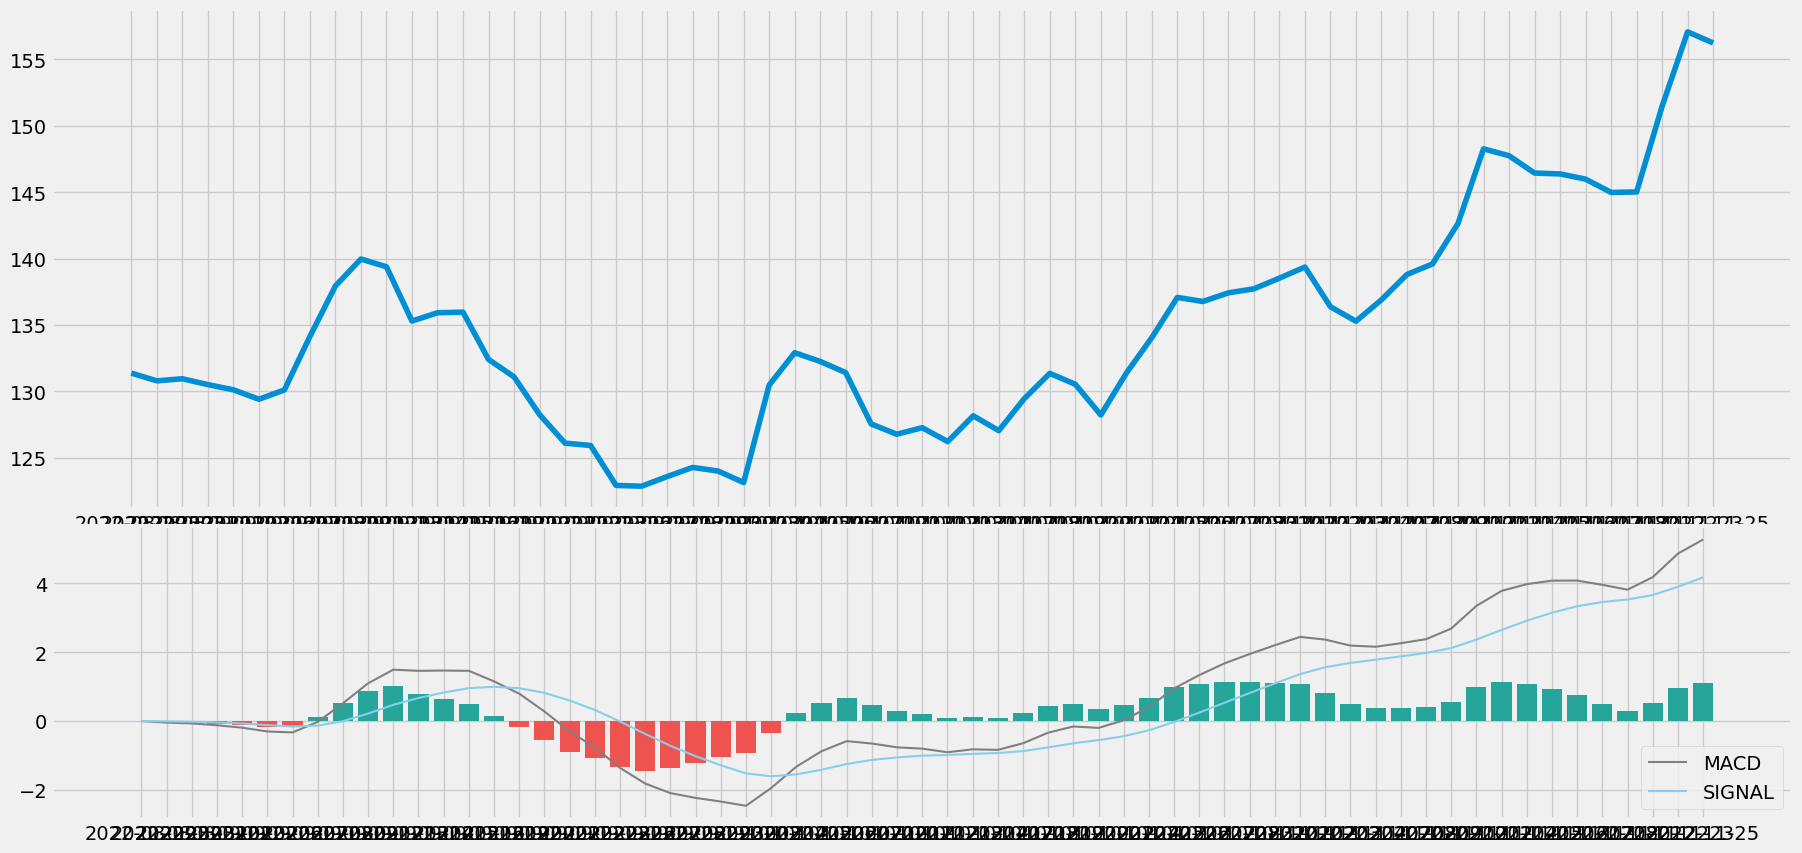

In [10]:
plot_macd(a['Close'], a_macd['macd'], a_macd['signal'], a_macd['hist'])

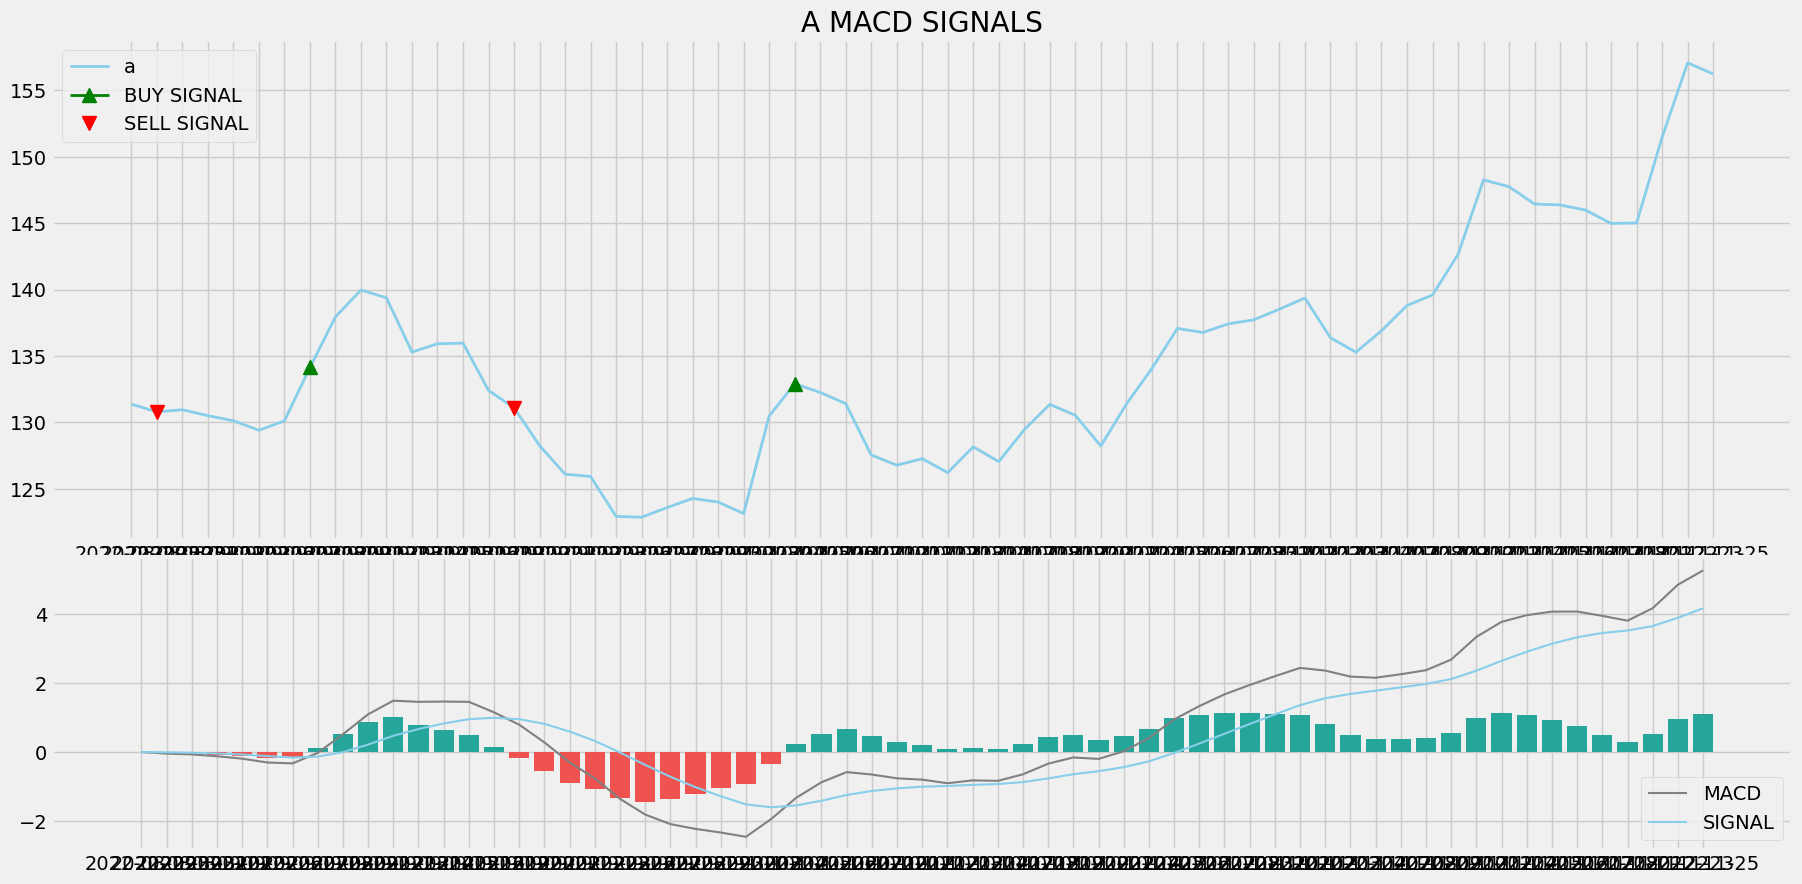

In [21]:
buy_price, sell_price, macd_signal = implement_macd_strategy(a['Close'], a_macd)
ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

ax1.plot(a['Close'], color = 'skyblue', linewidth = 2, label = 'a')
ax1.plot(a.index, buy_price, marker = '^', color = 'green', markersize = 10, label = 'BUY SIGNAL', linewidth = 2)
ax1.plot(a.index, sell_price, marker = 'v', color = 'r', markersize = 10, label = 'SELL SIGNAL', linewidth = 0)
ax1.legend()
ax1.set_title('A MACD SIGNALS')
ax2.plot(a_macd['macd'], color = 'grey', linewidth = 1.5, label = 'MACD')
ax2.plot(a_macd['signal'], color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

for i in range(len(a_macd)):
    if str(a_macd['hist'][i])[0] == '-':
        ax2.bar(a_macd.index[i], a_macd['hist'][i], color = '#ef5350')
    else:
        ax2.bar(a_macd.index[i], a_macd['hist'][i], color = '#26a69a')
        
plt.legend(loc = 'lower right')
plt.show()

#### The strategy of stock 'ALLE'.

In [9]:
a_macd = get_macd(alle['Close'], 26, 12, 9)
buy_price, sell_price, macd_signal = implement_macd_strategy(alle['Close'], a_macd)

# creating the position
position = []
for i in range(len(macd_signal)):
    if macd_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(alle['Close'])):
    if macd_signal[i] == 1:
        position[i] = 1
    elif macd_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
macd = a_macd['macd']
signal = a_macd['signal']
close_price = alle['Close']
macd_signal = pd.DataFrame(macd_signal).rename(columns = {0:'macd_signal'}).set_index(alle.index)
position = pd.DataFrame(position).rename(columns = {0:'macd_position'}).set_index(alle.index)

frames = [close_price, macd, signal, macd_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

# backtesting
a_ret = pd.DataFrame(np.diff(alle['Close'])).rename(columns = {0:'returns'})
macd_strategy_ret = []

for i in range(len(a_ret)):
    try:
        returns = a_ret['returns'][i]*strategy['macd_position'][i]
        macd_strategy_ret.append(returns)
    except:
        pass
    
macd_strategy_ret_df = pd.DataFrame(macd_strategy_ret).rename(columns = {0:'macd_returns'})

investment_value = w_alle #initial invest
number_of_stocks = floor(investment_value/alle['Close'][0])
macd_investment_ret = []

for i in range(len(macd_strategy_ret_df['macd_returns'])):
    returns = number_of_stocks*macd_strategy_ret_df['macd_returns'][i]
    macd_investment_ret.append(returns)

macd_investment_ret_df = pd.DataFrame(macd_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(macd_investment_ret_df['investment_returns']), 2)
profit_percentage = floor((total_investment_ret/investment_value)*100)
print(cl('Profit gained from the MACD strategy by investing in alle : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the MACD strategy : {}%'.format(profit_percentage), attrs = ['bold']))

Profit gained from the MACD strategy by investing in alle : 111.05
Profit percentage of the MACD strategy : 9%


In [10]:
strategy.to_excel ('ALLE.xls', header=True)

/var/folders/ph/vx5nhd9n6hd1sjhmzjz9gr7r0000gn/T/ipykernel_39475/3739711838.py:1: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  strategy.to_excel ('ALLE.xls', header=True)


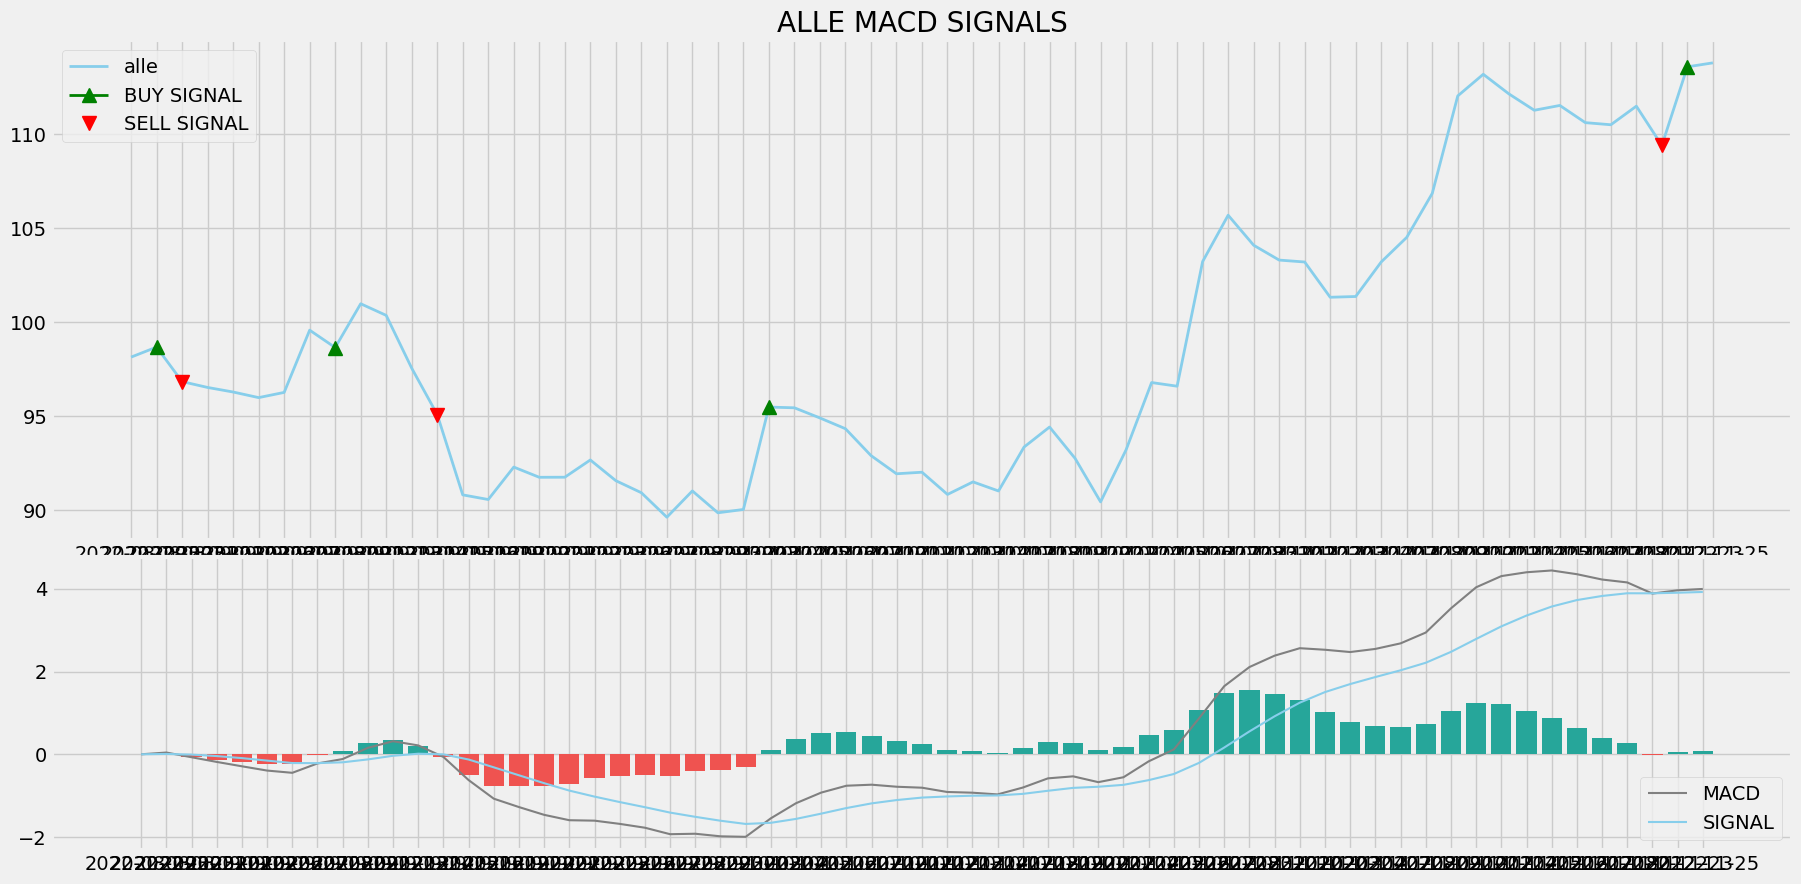

In [24]:
buy_price, sell_price, macd_signal = implement_macd_strategy(alle['Close'], a_macd)
ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

ax1.plot(alle['Close'], color = 'skyblue', linewidth = 2, label = 'alle')
ax1.plot(alle.index, buy_price, marker = '^', color = 'green', markersize = 10, label = 'BUY SIGNAL', linewidth = 2)
ax1.plot(alle.index, sell_price, marker = 'v', color = 'r', markersize = 10, label = 'SELL SIGNAL', linewidth = 0)
ax1.legend()
ax1.set_title('ALLE MACD SIGNALS')
ax2.plot(a_macd['macd'], color = 'grey', linewidth = 1.5, label = 'MACD')
ax2.plot(a_macd['signal'], color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

for i in range(len(a_macd)):
    if str(a_macd['hist'][i])[0] == '-':
        ax2.bar(a_macd.index[i], a_macd['hist'][i], color = '#ef5350')
    else:
        ax2.bar(a_macd.index[i], a_macd['hist'][i], color = '#26a69a')
        
plt.legend(loc = 'lower right')
plt.show()

#### The strategy of stock 'AMGN'.

In [25]:
a_macd = get_macd(amgn['Close'], 26, 12, 9)
buy_price, sell_price, macd_signal = implement_macd_strategy(amgn['Close'], a_macd)

# creating the position
position = []
for i in range(len(macd_signal)):
    if macd_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(amgn['Close'])):
    if macd_signal[i] == 1:
        position[i] = 1
    elif macd_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
macd = a_macd['macd']
signal = a_macd['signal']
close_price = amgn['Close']
macd_signal = pd.DataFrame(macd_signal).rename(columns = {0:'macd_signal'}).set_index(amgn.index)
position = pd.DataFrame(position).rename(columns = {0:'macd_position'}).set_index(amgn.index)

frames = [close_price, macd, signal, macd_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

# backtesting
a_ret = pd.DataFrame(np.diff(amgn['Close'])).rename(columns = {0:'returns'})
macd_strategy_ret = []

for i in range(len(a_ret)):
    try:
        returns = a_ret['returns'][i]*strategy['macd_position'][i]
        macd_strategy_ret.append(returns)
    except:
        pass
    
macd_strategy_ret_df = pd.DataFrame(macd_strategy_ret).rename(columns = {0:'macd_returns'})

investment_value = w_amgn #initial invest
number_of_stocks = floor(investment_value/amgn['Close'][0])
macd_investment_ret = []

for i in range(len(macd_strategy_ret_df['macd_returns'])):
    returns = number_of_stocks*macd_strategy_ret_df['macd_returns'][i]
    macd_investment_ret.append(returns)

macd_investment_ret_df = pd.DataFrame(macd_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(macd_investment_ret_df['investment_returns']), 2)
profit_percentage = floor((total_investment_ret/investment_value)*100)
print(cl('Profit gained from the MACD strategy by investing in amgn : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the MACD strategy : {}%'.format(profit_percentage), attrs = ['bold']))

Profit gained from the MACD strategy by investing in amgn : 463.87
Profit percentage of the MACD strategy : 15%


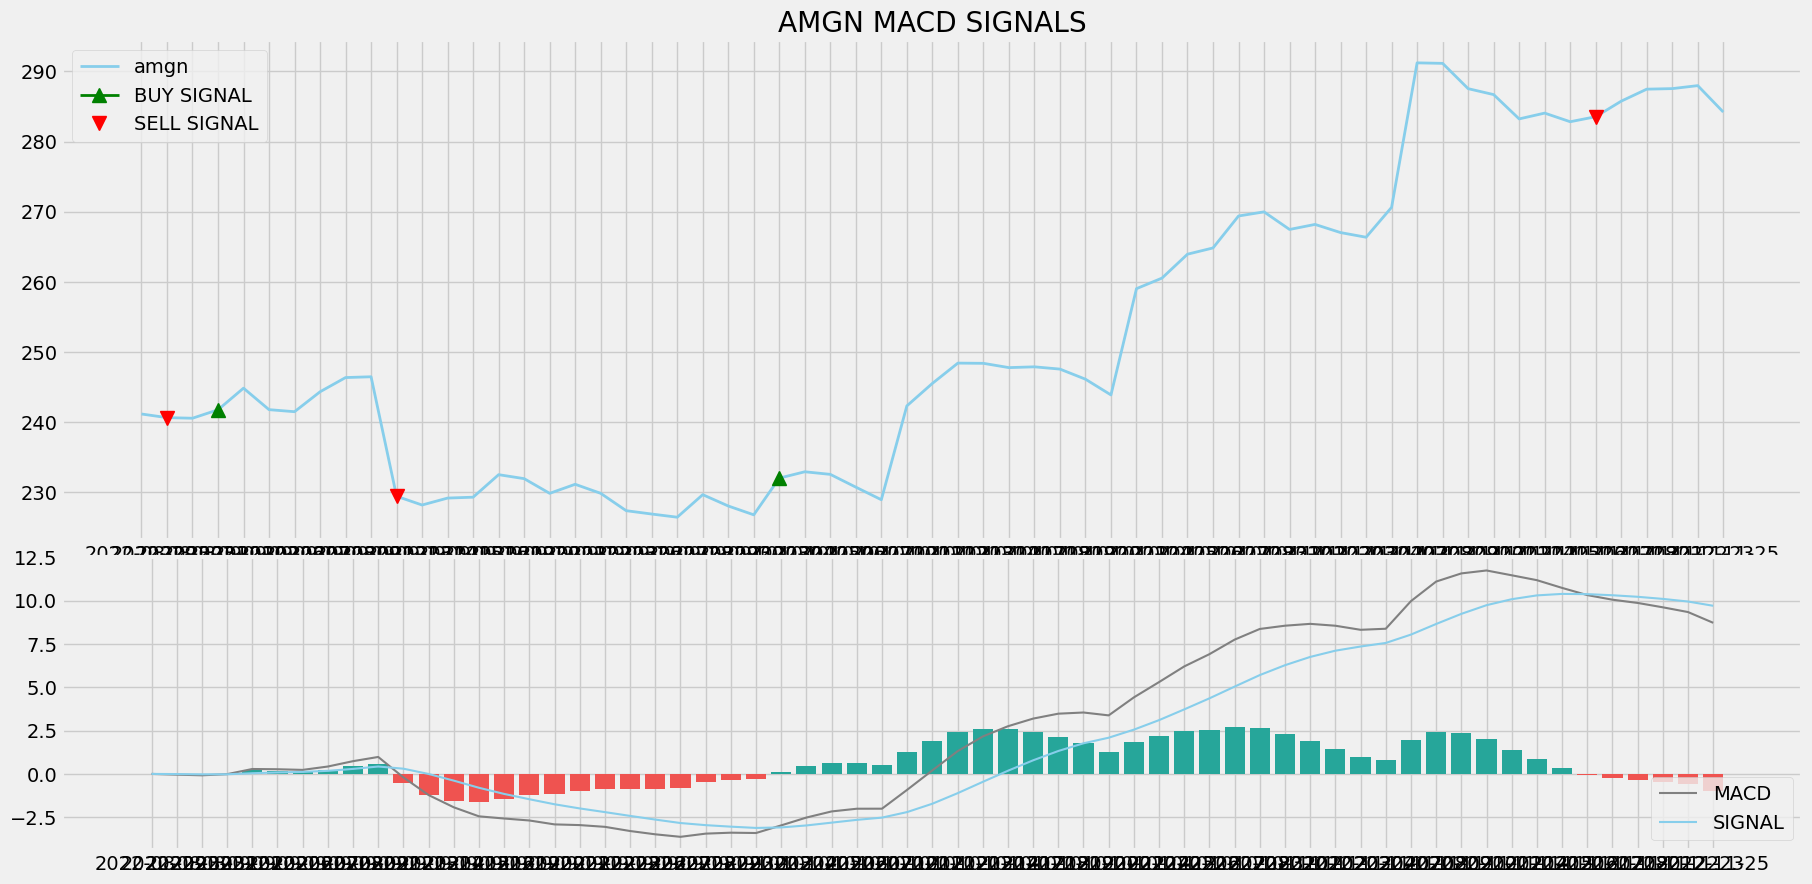

In [26]:
buy_price, sell_price, macd_signal = implement_macd_strategy(amgn['Close'], a_macd)
ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

ax1.plot(amgn['Close'], color = 'skyblue', linewidth = 2, label = 'amgn')
ax1.plot(amgn.index, buy_price, marker = '^', color = 'green', markersize = 10, label = 'BUY SIGNAL', linewidth = 2)
ax1.plot(amgn.index, sell_price, marker = 'v', color = 'r', markersize = 10, label = 'SELL SIGNAL', linewidth = 0)
ax1.legend()
ax1.set_title('AMGN MACD SIGNALS')
ax2.plot(a_macd['macd'], color = 'grey', linewidth = 1.5, label = 'MACD')
ax2.plot(a_macd['signal'], color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

for i in range(len(a_macd)):
    if str(a_macd['hist'][i])[0] == '-':
        ax2.bar(a_macd.index[i], a_macd['hist'][i], color = '#ef5350')
    else:
        ax2.bar(a_macd.index[i], a_macd['hist'][i], color = '#26a69a')
        
plt.legend(loc = 'lower right')
plt.show()

#### The strategy of stock 'BIIB'.

In [28]:
a_macd = get_macd(biib['Close'], 26, 12, 9)
buy_price, sell_price, macd_signal = implement_macd_strategy(biib['Close'], a_macd)

# creating the position
position = []
for i in range(len(macd_signal)):
    if macd_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(biib['Close'])):
    if macd_signal[i] == 1:
        position[i] = 1
    elif macd_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
macd = a_macd['macd']
signal = a_macd['signal']
close_price = biib['Close']
macd_signal = pd.DataFrame(macd_signal).rename(columns = {0:'macd_signal'}).set_index(biib.index)
position = pd.DataFrame(position).rename(columns = {0:'macd_position'}).set_index(biib.index)

frames = [close_price, macd, signal, macd_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

# backtesting
biib_ret = pd.DataFrame(np.diff(biib['Close'])).rename(columns = {0:'returns'})
macd_strategy_ret = []

for i in range(len(a_ret)):
    try:
        returns = biib_ret['returns'][i]*strategy['macd_position'][i]
        macd_strategy_ret.append(returns)
    except:
        pass
    
macd_strategy_ret_df = pd.DataFrame(macd_strategy_ret).rename(columns = {0:'macd_returns'})

investment_value = w_biib #initial invest
number_of_stocks = floor(investment_value/biib['Close'][0])
macd_investment_ret = []

for i in range(len(macd_strategy_ret_df['macd_returns'])):
    returns = number_of_stocks*macd_strategy_ret_df['macd_returns'][i]
    macd_investment_ret.append(returns)

macd_investment_ret_df = pd.DataFrame(macd_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(macd_investment_ret_df['investment_returns']), 2)
profit_percentage = floor((total_investment_ret/investment_value)*100)
print(cl('Profit gained from the MACD strategy by investing in biib : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the MACD strategy : {}%'.format(profit_percentage), attrs = ['bold']))

Profit gained from the MACD strategy by investing in biib : 12.72
Profit percentage of the MACD strategy : 1%


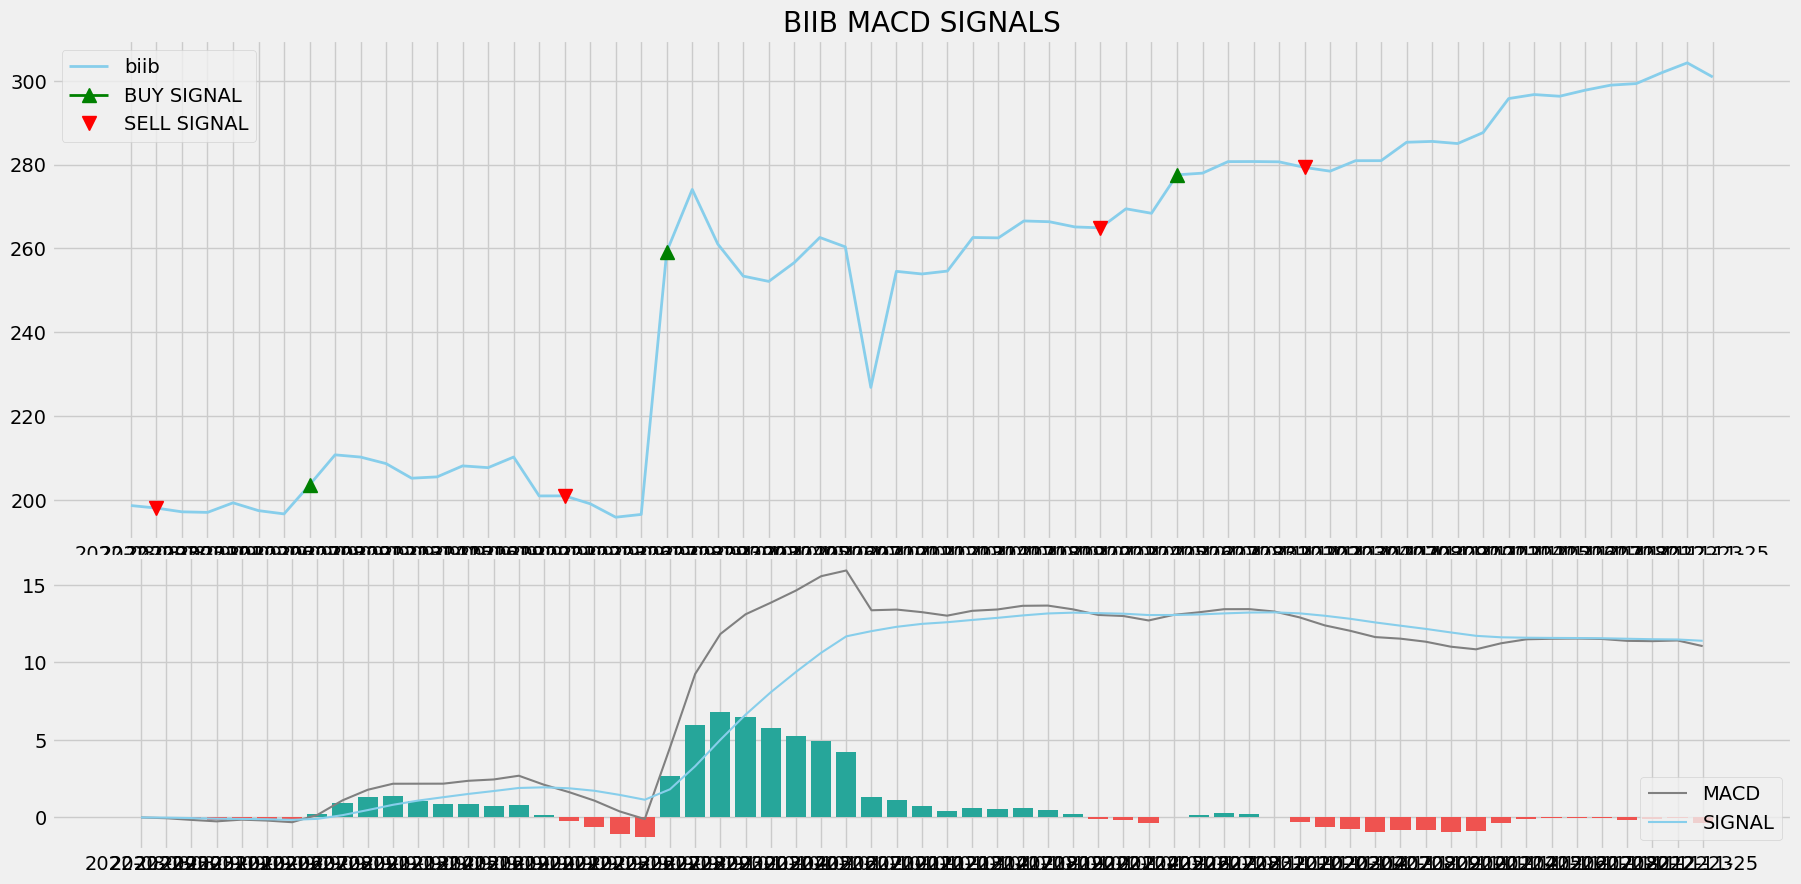

In [29]:
buy_price, sell_price, macd_signal = implement_macd_strategy(biib['Close'], a_macd)
ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

ax1.plot(biib['Close'], color = 'skyblue', linewidth = 2, label = 'biib')
ax1.plot(biib.index, buy_price, marker = '^', color = 'green', markersize = 10, label = 'BUY SIGNAL', linewidth = 2)
ax1.plot(biib.index, sell_price, marker = 'v', color = 'r', markersize = 10, label = 'SELL SIGNAL', linewidth = 0)
ax1.legend()
ax1.set_title('BIIB MACD SIGNALS')
ax2.plot(a_macd['macd'], color = 'grey', linewidth = 1.5, label = 'MACD')
ax2.plot(a_macd['signal'], color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

for i in range(len(a_macd)):
    if str(a_macd['hist'][i])[0] == '-':
        ax2.bar(a_macd.index[i], a_macd['hist'][i], color = '#ef5350')
    else:
        ax2.bar(a_macd.index[i], a_macd['hist'][i], color = '#26a69a')
        
plt.legend(loc = 'lower right')
plt.show()

#### The strategy of stock 'BMY'.

In [30]:
a_macd = get_macd(bmy['Close'], 26, 12, 9)
buy_price, sell_price, macd_signal = implement_macd_strategy(bmy['Close'], a_macd)

# creating the position
position = []
for i in range(len(macd_signal)):
    if macd_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(bmy['Close'])):
    if macd_signal[i] == 1:
        position[i] = 1
    elif macd_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
macd = a_macd['macd']
signal = a_macd['signal']
close_price = bmy['Close']
macd_signal = pd.DataFrame(macd_signal).rename(columns = {0:'macd_signal'}).set_index(bmy.index)
position = pd.DataFrame(position).rename(columns = {0:'macd_position'}).set_index(bmy.index)

frames = [close_price, macd, signal, macd_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

# backtesting
a_ret = pd.DataFrame(np.diff(bmy['Close'])).rename(columns = {0:'returns'})
macd_strategy_ret = []

for i in range(len(a_ret)):
    try:
        returns = a_ret['returns'][i]*strategy['macd_position'][i]
        macd_strategy_ret.append(returns)
    except:
        pass
    
macd_strategy_ret_df = pd.DataFrame(macd_strategy_ret).rename(columns = {0:'macd_returns'})

investment_value = w_bmy #initial invest
number_of_stocks = floor(investment_value/bmy['Close'][0])
macd_investment_ret = []

for i in range(len(macd_strategy_ret_df['macd_returns'])):
    returns = number_of_stocks*macd_strategy_ret_df['macd_returns'][i]
    macd_investment_ret.append(returns)

macd_investment_ret_df = pd.DataFrame(macd_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(macd_investment_ret_df['investment_returns']), 2)
profit_percentage = floor((total_investment_ret/investment_value)*100)
print(cl('Profit gained from the MACD strategy by investing in bmy : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the MACD strategy : {}%'.format(profit_percentage), attrs = ['bold']))

Profit gained from the MACD strategy by investing in bmy : 131.09
Profit percentage of the MACD strategy : 11%


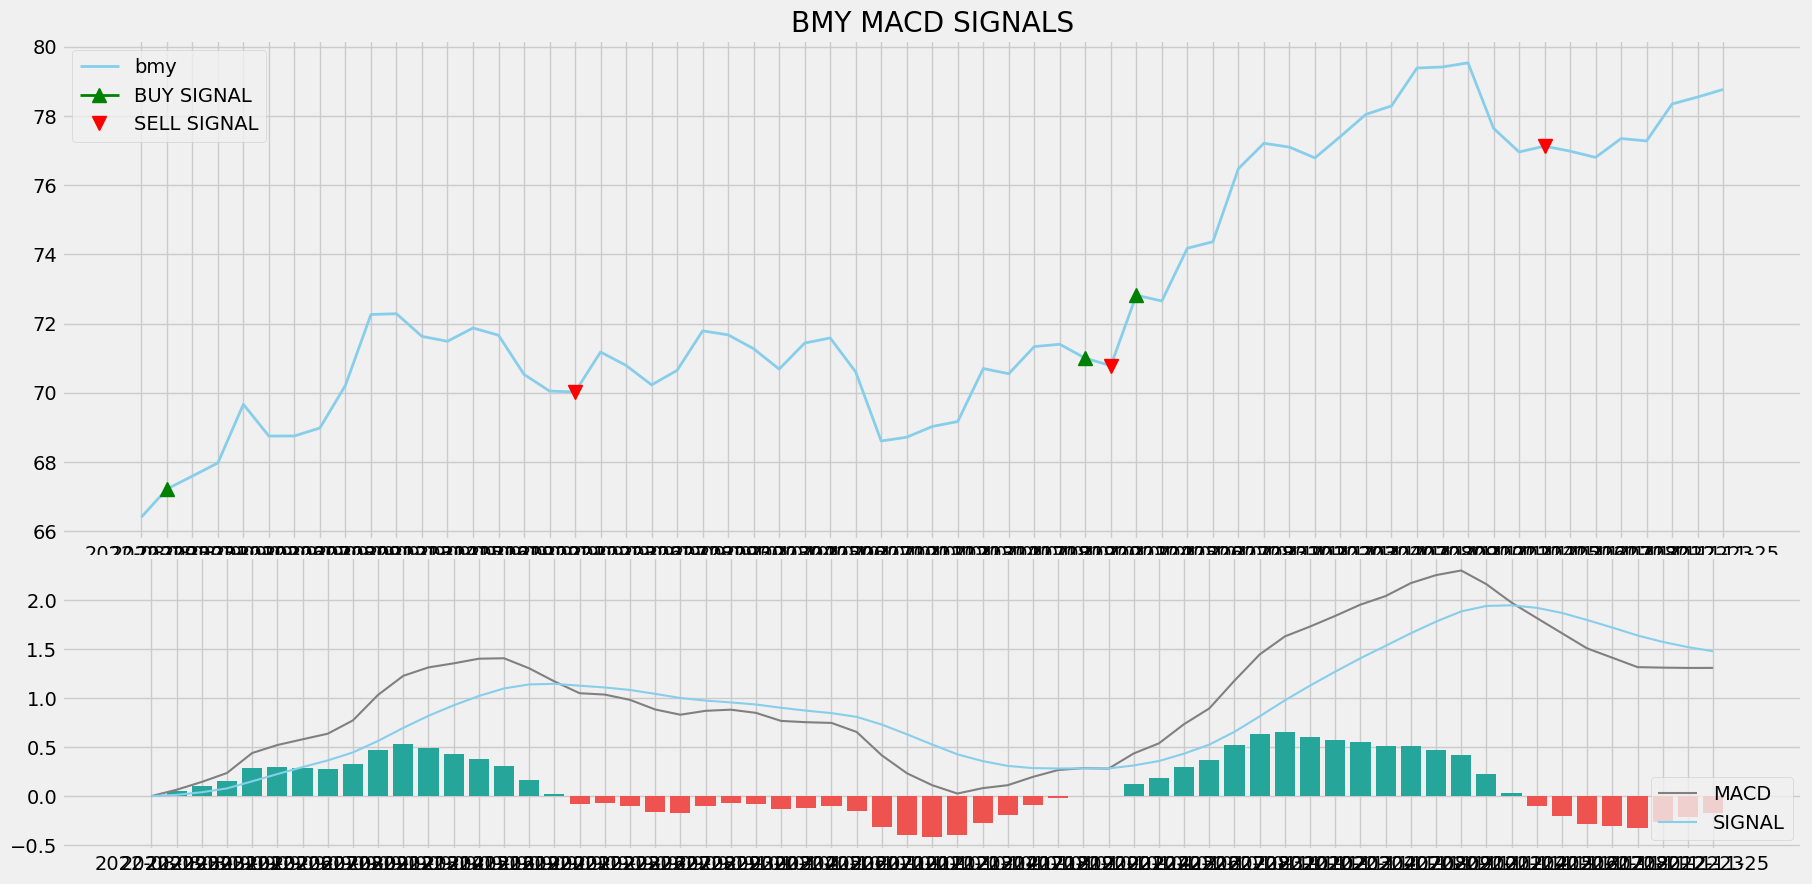

In [31]:
buy_price, sell_price, macd_signal = implement_macd_strategy(bmy['Close'], a_macd)
ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

ax1.plot(bmy['Close'], color = 'skyblue', linewidth = 2, label = 'bmy')
ax1.plot(bmy.index, buy_price, marker = '^', color = 'green', markersize = 10, label = 'BUY SIGNAL', linewidth = 2)
ax1.plot(bmy.index, sell_price, marker = 'v', color = 'r', markersize = 10, label = 'SELL SIGNAL', linewidth = 0)
ax1.legend()
ax1.set_title('BMY MACD SIGNALS')
ax2.plot(a_macd['macd'], color = 'grey', linewidth = 1.5, label = 'MACD')
ax2.plot(a_macd['signal'], color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

for i in range(len(a_macd)):
    if str(a_macd['hist'][i])[0] == '-':
        ax2.bar(a_macd.index[i], a_macd['hist'][i], color = '#ef5350')
    else:
        ax2.bar(a_macd.index[i], a_macd['hist'][i], color = '#26a69a')
        
plt.legend(loc = 'lower right')
plt.show()

#### The strategy of stock 'CAT'.

In [32]:
a_macd = get_macd(cat['Close'], 26, 12, 9)
buy_price, sell_price, macd_signal = implement_macd_strategy(cat['Close'], a_macd)

# creating the position
position = []
for i in range(len(macd_signal)):
    if macd_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(cat['Close'])):
    if macd_signal[i] == 1:
        position[i] = 1
    elif macd_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
macd = a_macd['macd']
signal = a_macd['signal']
close_price = cat['Close']
macd_signal = pd.DataFrame(macd_signal).rename(columns = {0:'macd_signal'}).set_index(cat.index)
position = pd.DataFrame(position).rename(columns = {0:'macd_position'}).set_index(cat.index)

frames = [close_price, macd, signal, macd_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

# backtesting
a_ret = pd.DataFrame(np.diff(cat['Close'])).rename(columns = {0:'returns'})
macd_strategy_ret = []

for i in range(len(a_ret)):
    try:
        returns = a_ret['returns'][i]*strategy['macd_position'][i]
        macd_strategy_ret.append(returns)
    except:
        pass
    
macd_strategy_ret_df = pd.DataFrame(macd_strategy_ret).rename(columns = {0:'macd_returns'})

investment_value = w_cat #initial invest
number_of_stocks = floor(investment_value/cat['Close'][0])
macd_investment_ret = []

for i in range(len(macd_strategy_ret_df['macd_returns'])):
    returns = number_of_stocks*macd_strategy_ret_df['macd_returns'][i]
    macd_investment_ret.append(returns)

macd_investment_ret_df = pd.DataFrame(macd_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(macd_investment_ret_df['investment_returns']), 2)
profit_percentage = floor((total_investment_ret/investment_value)*100)
print(cl('Profit gained from the MACD strategy by investing in cat : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the MACD strategy : {}%'.format(profit_percentage), attrs = ['bold']))

Profit gained from the MACD strategy by investing in cat : 116.38
Profit percentage of the MACD strategy : 16%


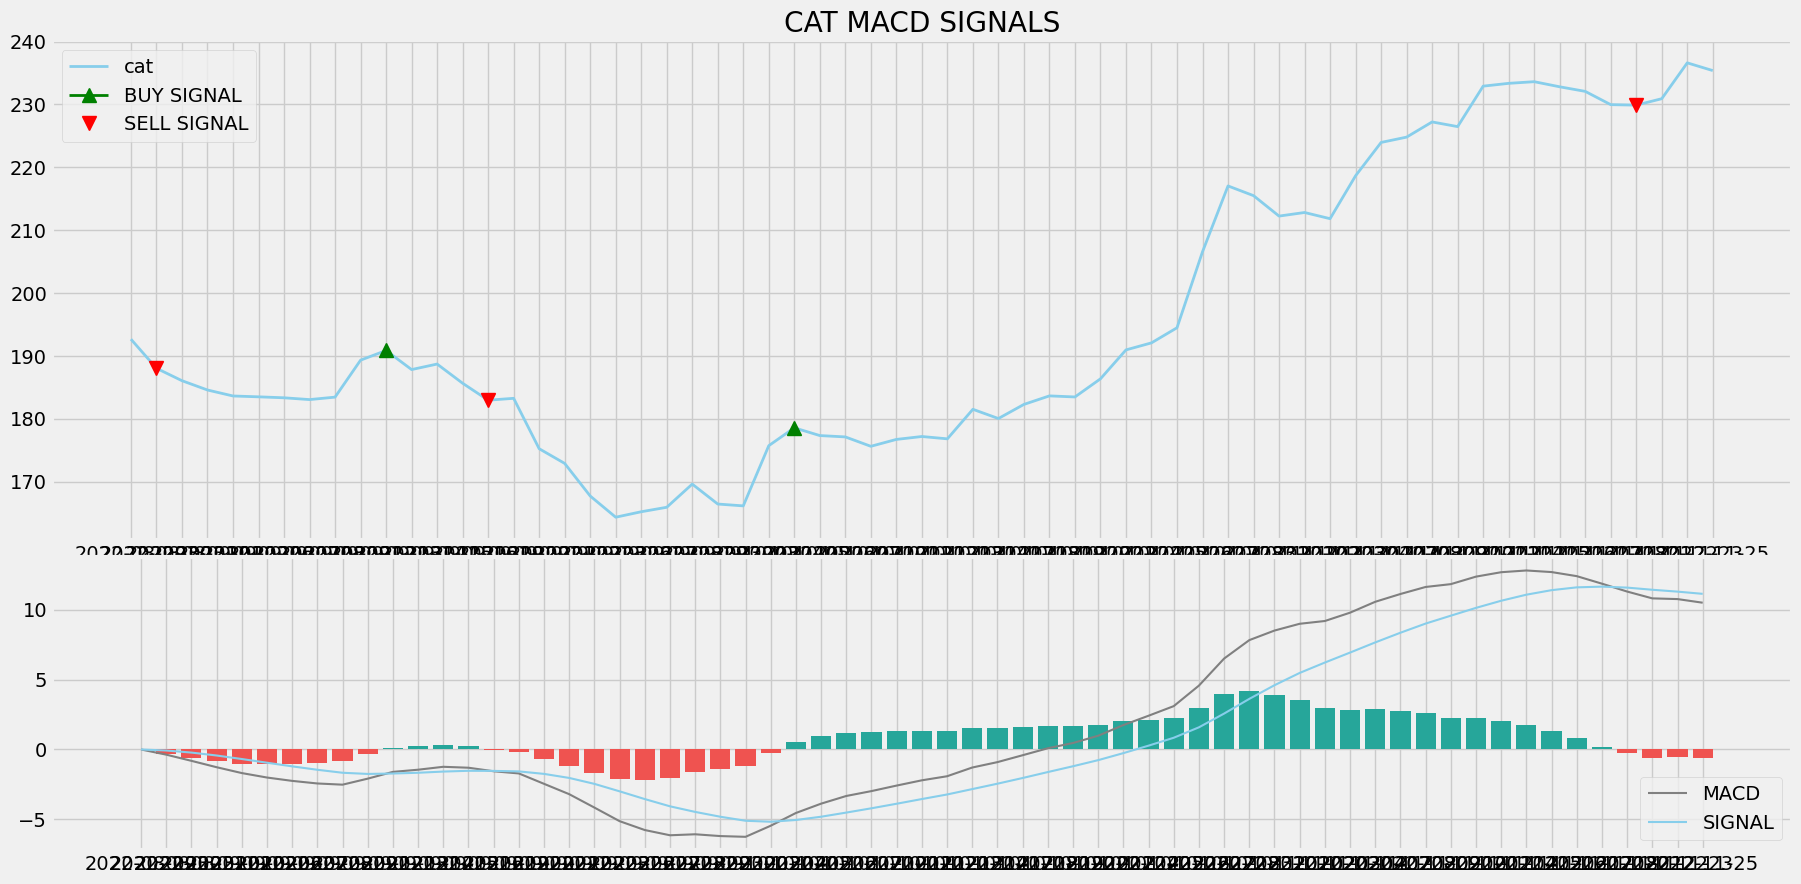

In [33]:
buy_price, sell_price, macd_signal = implement_macd_strategy(cat['Close'], a_macd)
ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

ax1.plot(cat['Close'], color = 'skyblue', linewidth = 2, label = 'cat')
ax1.plot(cat.index, buy_price, marker = '^', color = 'green', markersize = 10, label = 'BUY SIGNAL', linewidth = 2)
ax1.plot(cat.index, sell_price, marker = 'v', color = 'r', markersize = 10, label = 'SELL SIGNAL', linewidth = 0)
ax1.legend()
ax1.set_title('CAT MACD SIGNALS')
ax2.plot(a_macd['macd'], color = 'grey', linewidth = 1.5, label = 'MACD')
ax2.plot(a_macd['signal'], color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

for i in range(len(a_macd)):
    if str(a_macd['hist'][i])[0] == '-':
        ax2.bar(a_macd.index[i], a_macd['hist'][i], color = '#ef5350')
    else:
        ax2.bar(a_macd.index[i], a_macd['hist'][i], color = '#26a69a')
        
plt.legend(loc = 'lower right')
plt.show()

### Step 7: Compare with SPY ETF.

In [77]:
SPY = yf.download('SPY')
spy = SPY.truncate(before = '2022-08-27')['Close']
benchmark = pd.DataFrame(np.diff(spy)).rename(columns = {0:'benchmark_returns'})
benchmark

[*********************100%***********************]  1 of 1 completed


,benchmark_returns
0,-4.420013
1,-3.029999
2,1.240021
3,-4.180023
4,-1.479980
...,...
62,-6.419983
63,-0.679993
64,12.449982
65,-0.299988


In [78]:
benchmark = get_benchmark('2022-08-27', 10000)
investment_value = 10000
total_benchmark_investment_ret = round(benchmark['investment_returns'].sum(), 2)
total_benchmark_investment_ret

102.72

In [79]:
profit_percentage = round(2347.28/investment_value*100,2)

In [80]:
benchmark_profit_percentage = floor((total_benchmark_investment_ret/investment_value)*100)
print(cl('Benchmark profit by investing $10k : {}'.format(total_benchmark_investment_ret), attrs = ['bold']))
print(cl('Benchmark Profit percentage : {}%'.format(benchmark_profit_percentage), attrs = ['bold']))
print(cl('MACD Strategy profit is {}% higher than the Benchmark Profit'.format(profit_percentage - benchmark_profit_percentage), attrs = ['bold']))

Benchmark profit by investing $10k : 102.72
Benchmark Profit percentage : 1%
MACD Strategy profit is 22.47% higher than the Benchmark Profit


### Step 8: Stocks with worst performance.

In [18]:
atvi = data1['ATVI'].to_frame().rename(columns = {'ATVI':'Close'})
bdx = data1['BDX'].to_frame().rename(columns = {'BDX':'Close'})
chrw = data1['CHRW'].to_frame().rename(columns = {'CHRW':'Close'})
chd = data1['CHD'].to_frame().rename(columns = {'CHD':'Close'})

#### Allocate weights.

In [19]:
w_sum = 0.101 + 0.082 + 0.591 + 0.226
w_atvi = 0.101/w_sum *10000
w_bdx = 0.082/w_sum *10000
w_chrw = 0.591/w_sum *10000
w_chd = 0.226/w_sum *10000

#### The strategy of stock 'ATVI'.

In [20]:
a_macd = get_macd(atvi['Close'], 26, 12, 9)
buy_price, sell_price, macd_signal = implement_macd_strategy(atvi['Close'], a_macd)

# creating the position
position = []
for i in range(len(macd_signal)):
    if macd_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(atvi['Close'])):
    if macd_signal[i] == 1:
        position[i] = 0
    elif macd_signal[i] == -1:
        position[i] = 1
    else:
        position[i] = position[i-1]
        
macd = a_macd['macd']
signal = a_macd['signal']
close_price = atvi['Close']
macd_signal = pd.DataFrame(macd_signal).rename(columns = {0:'macd_signal'}).set_index(atvi.index)
position = pd.DataFrame(position).rename(columns = {0:'macd_position'}).set_index(atvi.index)

frames = [close_price, macd, signal, macd_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

# backtesting
a_ret = pd.DataFrame(np.diff(atvi['Close'])).rename(columns = {0:'returns'})
macd_strategy_ret = []

for i in range(len(a_ret)):
    try:
        returns = a_ret['returns'][i]*strategy['macd_position'][i]
        macd_strategy_ret.append(returns)
    except:
        pass
    
macd_strategy_ret_df = pd.DataFrame(macd_strategy_ret).rename(columns = {0:'macd_returns'})

investment_value = w_atvi #initial invest
number_of_stocks = floor(investment_value/atvi['Close'][0])
macd_investment_ret = []

for i in range(len(macd_strategy_ret_df['macd_returns'])):
    returns = number_of_stocks*macd_strategy_ret_df['macd_returns'][i]
    macd_investment_ret.append(returns)

macd_investment_ret_df = pd.DataFrame(macd_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(macd_investment_ret_df['investment_returns']), 2)
profit_percentage = floor((total_investment_ret/investment_value)*100)
print(cl('Profit gained from the MACD strategy by investing in atvi : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the MACD strategy : {}%'.format(profit_percentage), attrs = ['bold']))

Profit gained from the MACD strategy by investing in atvi : -47.67
Profit percentage of the MACD strategy : -5%


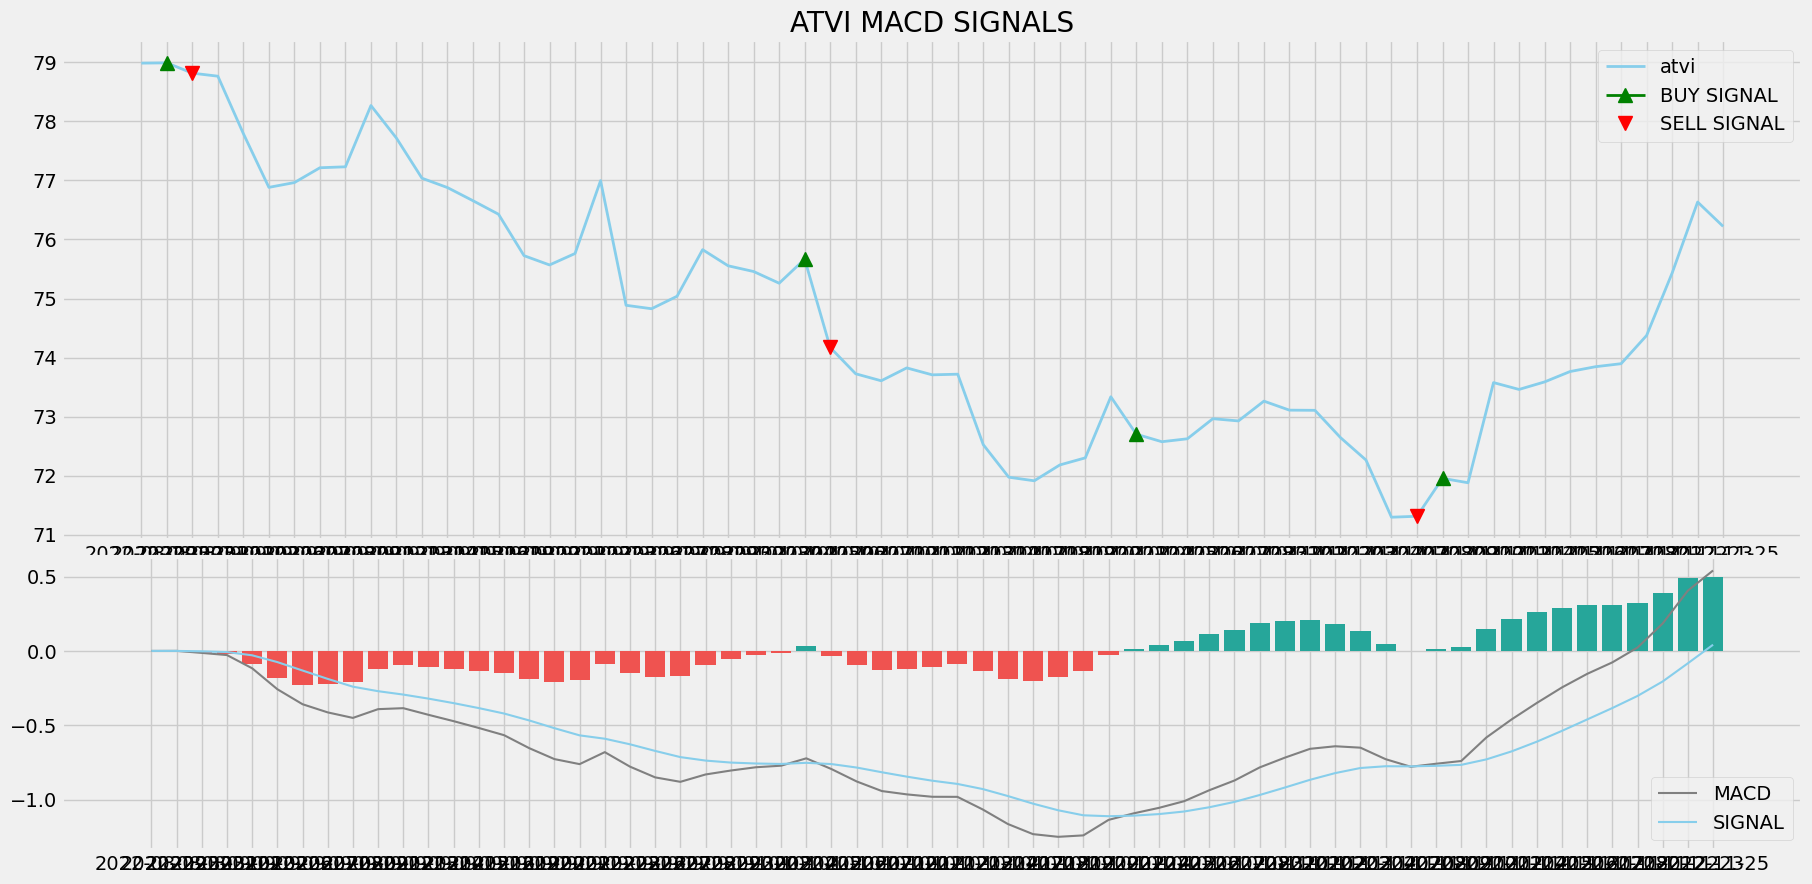

In [21]:
buy_price, sell_price, macd_signal = implement_macd_strategy(atvi['Close'], a_macd)
ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

ax1.plot(atvi['Close'], color = 'skyblue', linewidth = 2, label = 'atvi')
ax1.plot(atvi.index, buy_price, marker = '^', color = 'green', markersize = 10, label = 'BUY SIGNAL', linewidth = 2)
ax1.plot(atvi.index, sell_price, marker = 'v', color = 'r', markersize = 10, label = 'SELL SIGNAL', linewidth = 0)
ax1.legend()
ax1.set_title('ATVI MACD SIGNALS')
ax2.plot(a_macd['macd'], color = 'grey', linewidth = 1.5, label = 'MACD')
ax2.plot(a_macd['signal'], color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

for i in range(len(a_macd)):
    if str(a_macd['hist'][i])[0] == '-':
        ax2.bar(a_macd.index[i], a_macd['hist'][i], color = '#ef5350')
    else:
        ax2.bar(a_macd.index[i], a_macd['hist'][i], color = '#26a69a')
        
plt.legend(loc = 'lower right')
plt.show()

#### The strategy of stock 'BDX'.

In [22]:
a_macd = get_macd(bdx['Close'], 26, 12, 9)
buy_price, sell_price, macd_signal = implement_macd_strategy(bdx['Close'], a_macd)

# creating the position
position = []
for i in range(len(macd_signal)):
    if macd_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(bdx['Close'])):
    if macd_signal[i] == 1:
        position[i] = 0
    elif macd_signal[i] == -1:
        position[i] = 1
    else:
        position[i] = position[i-1]
        
macd = a_macd['macd']
signal = a_macd['signal']
close_price = bdx['Close']
macd_signal = pd.DataFrame(macd_signal).rename(columns = {0:'macd_signal'}).set_index(bdx.index)
position = pd.DataFrame(position).rename(columns = {0:'macd_position'}).set_index(bdx.index)

frames = [close_price, macd, signal, macd_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

# backtesting
a_ret = pd.DataFrame(np.diff(bdx['Close'])).rename(columns = {0:'returns'})
macd_strategy_ret = []

for i in range(len(a_ret)):
    try:
        returns = a_ret['returns'][i]*strategy['macd_position'][i]
        macd_strategy_ret.append(returns)
    except:
        pass
    
macd_strategy_ret_df = pd.DataFrame(macd_strategy_ret).rename(columns = {0:'macd_returns'})

investment_value = w_bdx #initial invest
number_of_stocks = floor(investment_value/bdx['Close'][0])
macd_investment_ret = []

for i in range(len(macd_strategy_ret_df['macd_returns'])):
    returns = number_of_stocks*macd_strategy_ret_df['macd_returns'][i]
    macd_investment_ret.append(returns)

macd_investment_ret_df = pd.DataFrame(macd_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(macd_investment_ret_df['investment_returns']), 2)
profit_percentage = floor((total_investment_ret/investment_value)*100)
print(cl('Profit gained from the MACD strategy by investing in bdx : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the MACD strategy : {}%'.format(profit_percentage), attrs = ['bold']))

Profit gained from the MACD strategy by investing in bdx : -47.32
Profit percentage of the MACD strategy : -6%


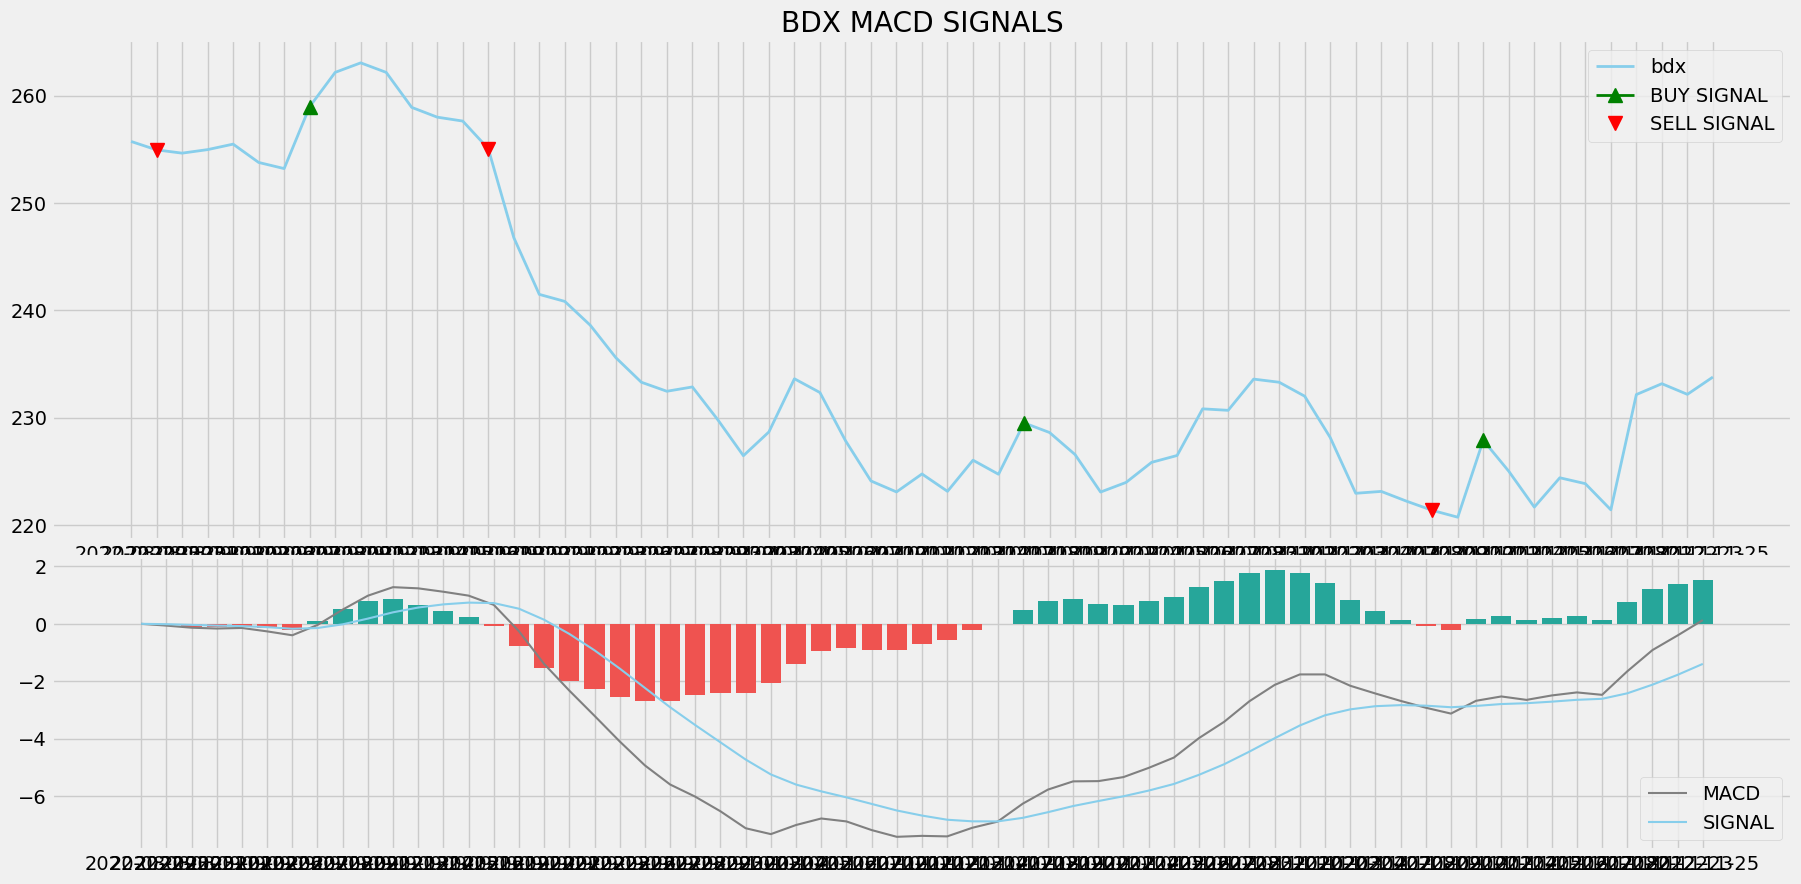

In [23]:
buy_price, sell_price, macd_signal = implement_macd_strategy(bdx['Close'], a_macd)
ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

ax1.plot(bdx['Close'], color = 'skyblue', linewidth = 2, label = 'bdx')
ax1.plot(bdx.index, buy_price, marker = '^', color = 'green', markersize = 10, label = 'BUY SIGNAL', linewidth = 2)
ax1.plot(bdx.index, sell_price, marker = 'v', color = 'r', markersize = 10, label = 'SELL SIGNAL', linewidth = 0)
ax1.legend()
ax1.set_title('BDX MACD SIGNALS')
ax2.plot(a_macd['macd'], color = 'grey', linewidth = 1.5, label = 'MACD')
ax2.plot(a_macd['signal'], color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

for i in range(len(a_macd)):
    if str(a_macd['hist'][i])[0] == '-':
        ax2.bar(a_macd.index[i], a_macd['hist'][i], color = '#ef5350')
    else:
        ax2.bar(a_macd.index[i], a_macd['hist'][i], color = '#26a69a')
        
plt.legend(loc = 'lower right')
plt.show()

#### The strategy of stock 'CHRW'.

In [24]:
a_macd = get_macd(chrw['Close'], 26, 12, 9)
buy_price, sell_price, macd_signal = implement_macd_strategy(chrw['Close'], a_macd)

# creating the position
position = []
for i in range(len(macd_signal)):
    if macd_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(chrw['Close'])):
    if macd_signal[i] == 1:
        position[i] = 0
    elif macd_signal[i] == -1:
        position[i] = 1
    else:
        position[i] = position[i-1]
        
macd = a_macd['macd']
signal = a_macd['signal']
close_price = chrw['Close']
macd_signal = pd.DataFrame(macd_signal).rename(columns = {0:'macd_signal'}).set_index(chrw.index)
position = pd.DataFrame(position).rename(columns = {0:'macd_position'}).set_index(chrw.index)

frames = [close_price, macd, signal, macd_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

# backtesting
a_ret = pd.DataFrame(np.diff(chrw['Close'])).rename(columns = {0:'returns'})
macd_strategy_ret = []

for i in range(len(a_ret)):
    try:
        returns = a_ret['returns'][i]*strategy['macd_position'][i]
        macd_strategy_ret.append(returns)
    except:
        pass
    
macd_strategy_ret_df = pd.DataFrame(macd_strategy_ret).rename(columns = {0:'macd_returns'})

investment_value = w_chrw #initial invest
number_of_stocks = floor(investment_value/chrw['Close'][0])
macd_investment_ret = []

for i in range(len(macd_strategy_ret_df['macd_returns'])):
    returns = number_of_stocks*macd_strategy_ret_df['macd_returns'][i]
    macd_investment_ret.append(returns)

macd_investment_ret_df = pd.DataFrame(macd_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(macd_investment_ret_df['investment_returns']), 2)
profit_percentage = floor((total_investment_ret/investment_value)*100)
print(cl('Profit gained from the MACD strategy by investing in chrw : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the MACD strategy : {}%'.format(profit_percentage), attrs = ['bold']))

Profit gained from the MACD strategy by investing in chrw : -444.51
Profit percentage of the MACD strategy : -8%


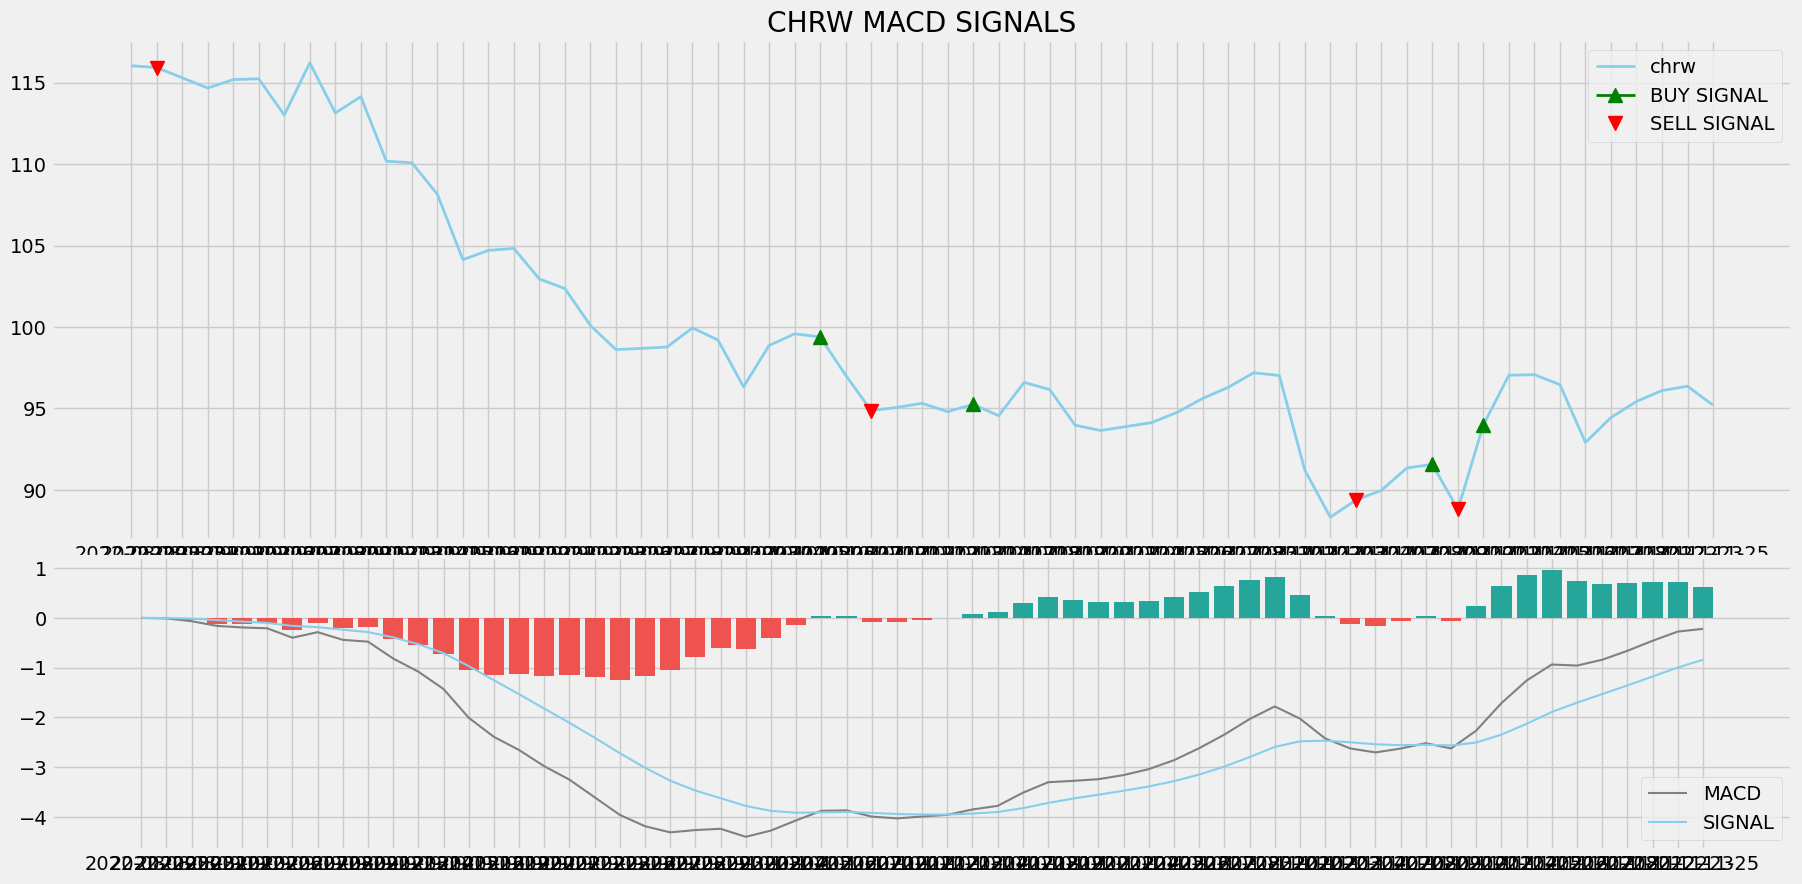

In [25]:
buy_price, sell_price, macd_signal = implement_macd_strategy(chrw['Close'], a_macd)
ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

ax1.plot(chrw['Close'], color = 'skyblue', linewidth = 2, label = 'chrw')
ax1.plot(chrw.index, buy_price, marker = '^', color = 'green', markersize = 10, label = 'BUY SIGNAL', linewidth = 2)
ax1.plot(chrw.index, sell_price, marker = 'v', color = 'r', markersize = 10, label = 'SELL SIGNAL', linewidth = 0)
ax1.legend()
ax1.set_title('CHRW MACD SIGNALS')
ax2.plot(a_macd['macd'], color = 'grey', linewidth = 1.5, label = 'MACD')
ax2.plot(a_macd['signal'], color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

for i in range(len(a_macd)):
    if str(a_macd['hist'][i])[0] == '-':
        ax2.bar(a_macd.index[i], a_macd['hist'][i], color = '#ef5350')
    else:
        ax2.bar(a_macd.index[i], a_macd['hist'][i], color = '#26a69a')
        
plt.legend(loc = 'lower right')
plt.show()

#### The strategy of stock 'CHD'.

In [26]:
a_macd = get_macd(chd['Close'], 26, 12, 9)
buy_price, sell_price, macd_signal = implement_macd_strategy(chd['Close'], a_macd)

# creating the position
position = []
for i in range(len(macd_signal)):
    if macd_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(chd['Close'])):
    if macd_signal[i] == 1:
        position[i] = 0
    elif macd_signal[i] == -1:
        position[i] = 1
    else:
        position[i] = position[i-1]
        
macd = a_macd['macd']
signal = a_macd['signal']
close_price = chd['Close']
macd_signal = pd.DataFrame(macd_signal).rename(columns = {0:'macd_signal'}).set_index(chd.index)
position = pd.DataFrame(position).rename(columns = {0:'macd_position'}).set_index(chd.index)

frames = [close_price, macd, signal, macd_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

# backtesting
chd_ret = pd.DataFrame(np.diff(chd['Close'])).rename(columns = {0:'returns'})
macd_strategy_ret = []

for i in range(len(a_ret)):
    try:
        returns = chd_ret['returns'][i]*strategy['macd_position'][i]
        macd_strategy_ret.append(returns)
    except:
        pass
    
macd_strategy_ret_df = pd.DataFrame(macd_strategy_ret).rename(columns = {0:'macd_returns'})

investment_value = w_chd#w_chd #initial invest
number_of_stocks = floor(investment_value/chd['Close'][0])
macd_investment_ret = []

for i in range(len(macd_strategy_ret_df['macd_returns'])):
    returns = number_of_stocks*macd_strategy_ret_df['macd_returns'][i]
    macd_investment_ret.append(returns)

macd_investment_ret_df = pd.DataFrame(macd_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(macd_investment_ret_df['investment_returns']), 2)
profit_percentage = floor((total_investment_ret/investment_value)*100)
print(cl('Profit gained from the MACD strategy by investing in chd : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the MACD strategy : {}%'.format(profit_percentage), attrs = ['bold']))

Profit gained from the MACD strategy by investing in chd : -334.08
Profit percentage of the MACD strategy : -15%


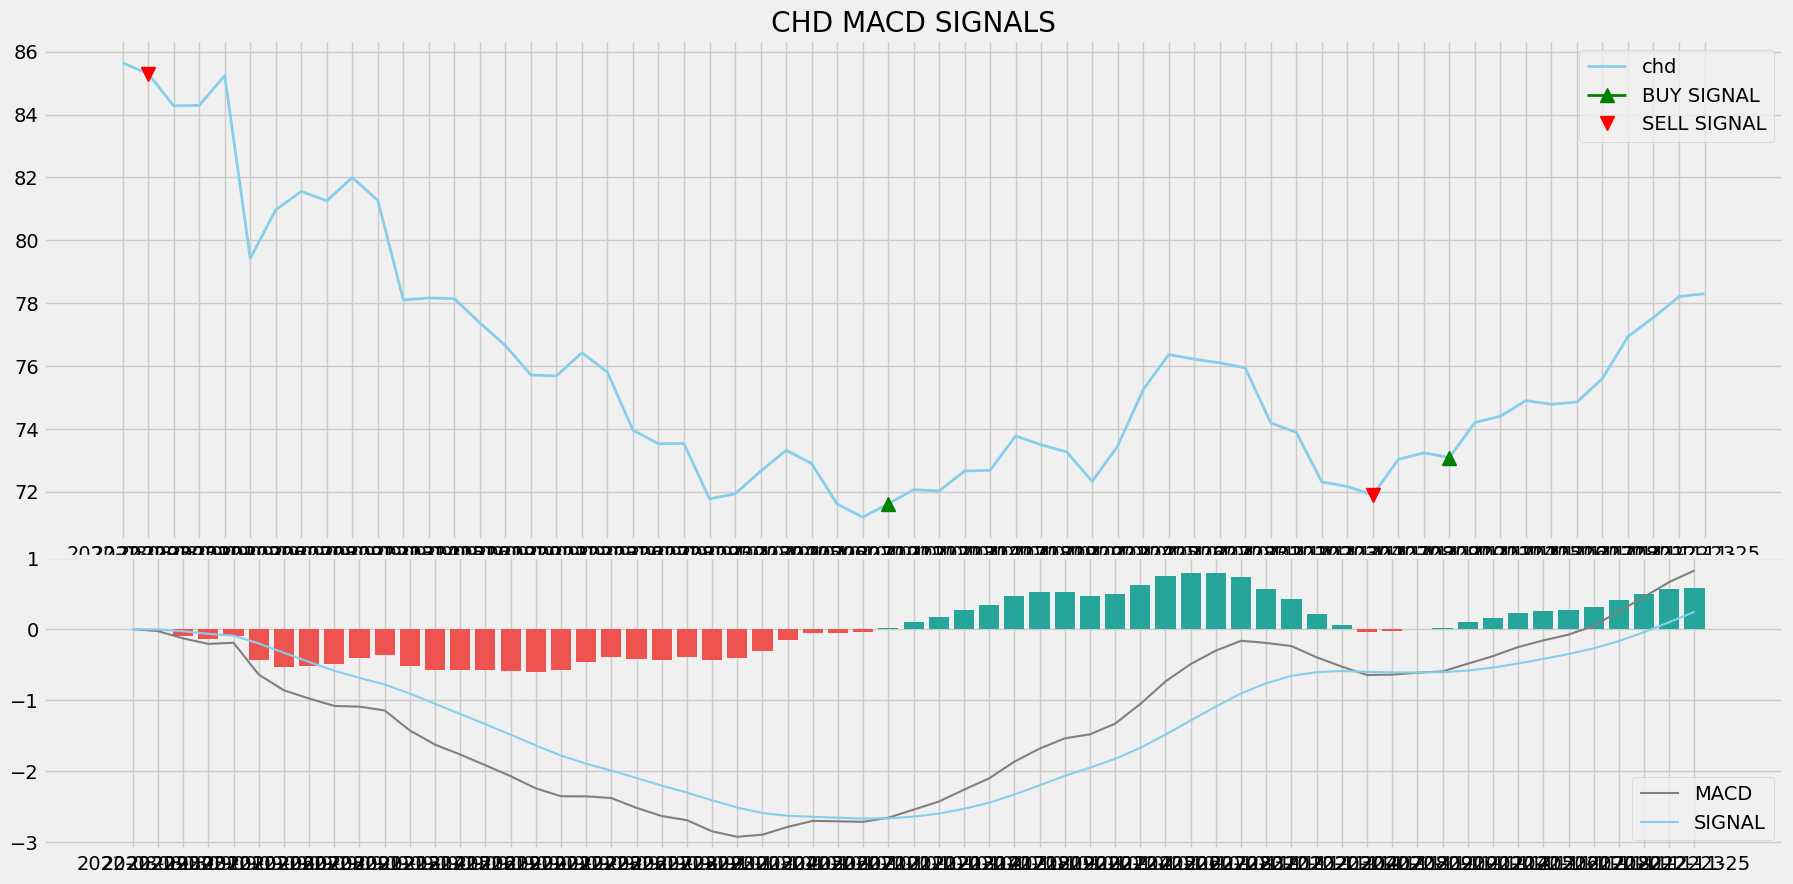

In [27]:
buy_price, sell_price, macd_signal = implement_macd_strategy(chd['Close'], a_macd)
ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

ax1.plot(chd['Close'], color = 'skyblue', linewidth = 2, label = 'chd')
ax1.plot(chd.index, buy_price, marker = '^', color = 'green', markersize = 10, label = 'BUY SIGNAL', linewidth = 2)
ax1.plot(chd.index, sell_price, marker = 'v', color = 'r', markersize = 10, label = 'SELL SIGNAL', linewidth = 0)
ax1.legend()
ax1.set_title('CHD MACD SIGNALS')
ax2.plot(a_macd['macd'], color = 'grey', linewidth = 1.5, label = 'MACD')
ax2.plot(a_macd['signal'], color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

for i in range(len(a_macd)):
    if str(a_macd['hist'][i])[0] == '-':
        ax2.bar(a_macd.index[i], a_macd['hist'][i], color = '#ef5350')
    else:
        ax2.bar(a_macd.index[i], a_macd['hist'][i], color = '#26a69a')
        
plt.legend(loc = 'lower right')
plt.show()